In [1]:
import numpy as np
import os
import inspect
from math import *
from IPython.display import clear_output
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
rent = 10 #10
cost1 = 2 #2
additional_park_cost = 4
expected_request1 = 3 #lambda #3
expected_request2 = 4 #lambda #4
expected_return1 = 3 #3
expected_return2 = 2 #2
max_cars = 20 #10
max_car_move = 5 #5
no_of_states = 21*21
no_of_possible_actions = 21
actions = np.arange(-max_car_move,max_car_move+1,1)
discount = .9
policy = np.zeros((21, 21))# current policy
state_value = np.zeros((21, 21))
next_states = []
theta = 1e-4

In [3]:
A = dict()
def poisson(n,l):
    global A
    if n-l>=6:
        return 0
    else:
        key = l*10 + n
        if key not in A.keys():
            A[key] = np.exp(-l) * pow(l, n) / factorial(n)
        return A[key]

In [4]:
def expected_return(state, action, state_value):
    returns = 0.0
    returns = returns- cost1 * np.absolute(action)
    if action > 0:                        #friend saves cost of 2 in free trip to second loc.
        returns -= cost1 * (action - 1)
    else:
        returns -= cost1 * abs(action)
    for rent1 in range(0, 9):
        for rent2 in range(0, 10):
            prob = poisson(rent1, expected_request1) * \
                         poisson(rent2, expected_request2)
            cars1 = int(min(state[0] - action, max_cars))
            cars2 = int(min(state[1] + action, max_cars))
            cars_rented1 = min(cars1, expected_request1)
            cars_rented2 = min(cars2, expected_request2)
            reward = (cars_rented1 + cars_rented2) * rent
            if cars1 >= 10:
                reward -= additional_park_cost
            if cars2 >= 10:
                reward -= additional_park_cost
            cars1 -= cars_rented1
            cars2 -= cars_rented2
            cars_1_temp  = cars1
            cars_2_temp = cars2
            temp_prob = prob
           

            for new_rent1 in range(0, 9):
                for new_rent2 in range(0, 10):
                    temp_cars1 = cars1
                    temp_cars2 = cars2
                    temp_prob = prob
                    temp_cars1 = min(cars1 + new_rent1, max_cars)
                    temp_cars2= min(cars2 + new_rent2, max_cars)
                    temp_prob = poisson(new_rent1, expected_return1) * \
                                poisson(new_rent2, expected_return2) * prob
                    returns += temp_prob * (reward + discount * state_value[temp_cars1, temp_cars2])
    return returns

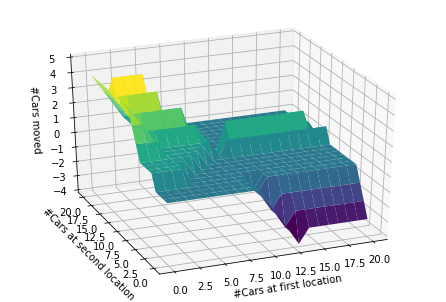

In [5]:
new_state_value = np.zeros((21, 21))
improve_policy = False
c = 0
states = []
for i in range(max_cars + 1):
    for j in range(max_cars + 1):
        states.append([i, j])
while True:
    if improve_policy == True:
        new_policy = np.zeros((21, 21))
        for i,j in states:
            action1 = []
            for action in actions:
                if (action >= 0 and i >= action) or (action < 0 and j >= abs(action)):
                    action1.append(expected_return([i, j], action, state_value))
                else:
                    action1.append(-float('inf'))
            optimal_action = np.argmax(action1)
            new_policy[i, j] = actions[optimal_action]
        policy_changes = np.sum(new_policy != policy)
        print ('Policy Changes-',policy_changes)
        if policy_changes == 0:
            policy = new_policy
            break
        policy = new_policy
        improve_policy = False

    print('Policy Evaluation')
    for i in range(max_cars+1):
            for j in range(max_cars+1):
                new_state_value[i, j] = expected_return([i, j], policy[i, j], state_value)
    if np.sum(np.abs(new_state_value - state_value)) < theta:
        state_value = new_state_value.copy()
        improve_policy = True
        continue
    state_value = new_state_value
    improve_policy = False
clear_output()
fig = plt.figure()
nx, ny = max_cars+1, max_cars+1
x = range(nx)
y = range(ny)
X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
ax = Axes3D(fig)
ax.set_xlabel('#Cars at first location')
ax.set_ylabel('#Cars at second location')
ax.set_zlabel('#Cars moved')
ax.view_init(azim = -112,elev = 30)
ax.plot_surface(X, Y, policy, cmap='viridis')